# Text mining

## List of papers

We first assembled the title, the name of the corresponding author, and the abstract for all the articles into a tabular-separated values (tsv) file, which we publicly archived on [Figshare](https://doi.org/10.6084/m9.figshare.5497468.v2). We use the [Repo2Data](https://github.com/SIMEXP/Repo2Data) tool developed by the NeuroLibre team to collect these data and include them in our reproducible computational environment.

In [1]:
from pathlib import Path

path_data = Path("../source_data/YNIMG_BrainParcellation_summary.tsv")

In [2]:
import os
import urllib.request
import pandas as pd
data = pd.read_csv(path_data, sep='\t',header=0)
# Show us the data!
pd.options.display.max_rows = 5
data

,Article,Author,Abstract
0,Functional atlas of the awake rat brain: a neu...,Ma,Connectivity-based parcellation approaches pre...
1,Automated individual-level parcellation of Bro...,Jakobsen,Broca's region can be subdivided into its cons...
...,...,...,...
36,An Exemplar-based Approach to Individualized P...,Salehi,Recent work with functional connectivity data ...
37,Predicting functional neuroanatomical maps fro...,Ganglberger,Functional neuroanatomical maps provide a meso...


## Word features
For each paper, we used [scikit-learn](http://scikit-learn.org) {cite:p}`Kramer2016` to extract a bag of words representation for each abstract, picking on the 300 most important terms seen across all articles based on a term frequency-inverse document frequency [(tf-idf) index](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Following that, a special value decomposition was used to further reduce the dimensionality of the abstracts to 10 components. We ended up with a component matrix of dimension 38 (articles) times 10 (abstract text components). The distribution of each of the 38 articles across the 10 components is represented below. Note how some articles have particular high loadings on specific components, suggesting these may capture particular topics. Rather than visually inspect the component loadings to group paper ourselves, we are going to resort to an automated parcellation (clustering) technique.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

# Prepare a model to extract a bag of words representation
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                             use_idf=True)
X = vectorizer.fit_transform(data.Abstract) # apply the TFIDF model to the abstracts of the papers
fts = vectorizer.get_feature_names_out() # Get the most relevant terms selected by the procedure
svd = TruncatedSVD(10, algorithm="arpack") # Prepare the SVD model
normalizer = Normalizer(copy=False) # Normalize the outputs of the svd
lsa = make_pipeline(svd, normalizer) # Put the SVD and normalization in a pipeline
X = lsa.fit_transform(X) # Apply the SVD to the TFIDF features

# Now make a radar plot with all the components
import plotly.express as px
import numpy as np
df_X = pd.DataFrame(data=np.concatenate([data['Author'].to_numpy().reshape([38, 1]), X], axis=1),
                    columns= np.concatenate([['First author'],[f'component {d}' for d in range(10)]]))
df_visu = pd.melt(df_X, id_vars='First author')
fig = px.line_polar(df_visu, r='value', theta='variable', color='First author', line_close=True,
            color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

## Parcellate the papers

Now that the content of each paper has been condensed into only 10 (hopefully informative) numbers, we can run these features into a trusted, classic parcellation algorithm: Ward's agglomerative hierarchical clustering, as implemented in the scipy library. We cut the hierarchy to extract 7 "paper parcels", and also use the hierarchy to re-order the papers, such that similar papers are close in order, as illustrated in a dendrogram representation.

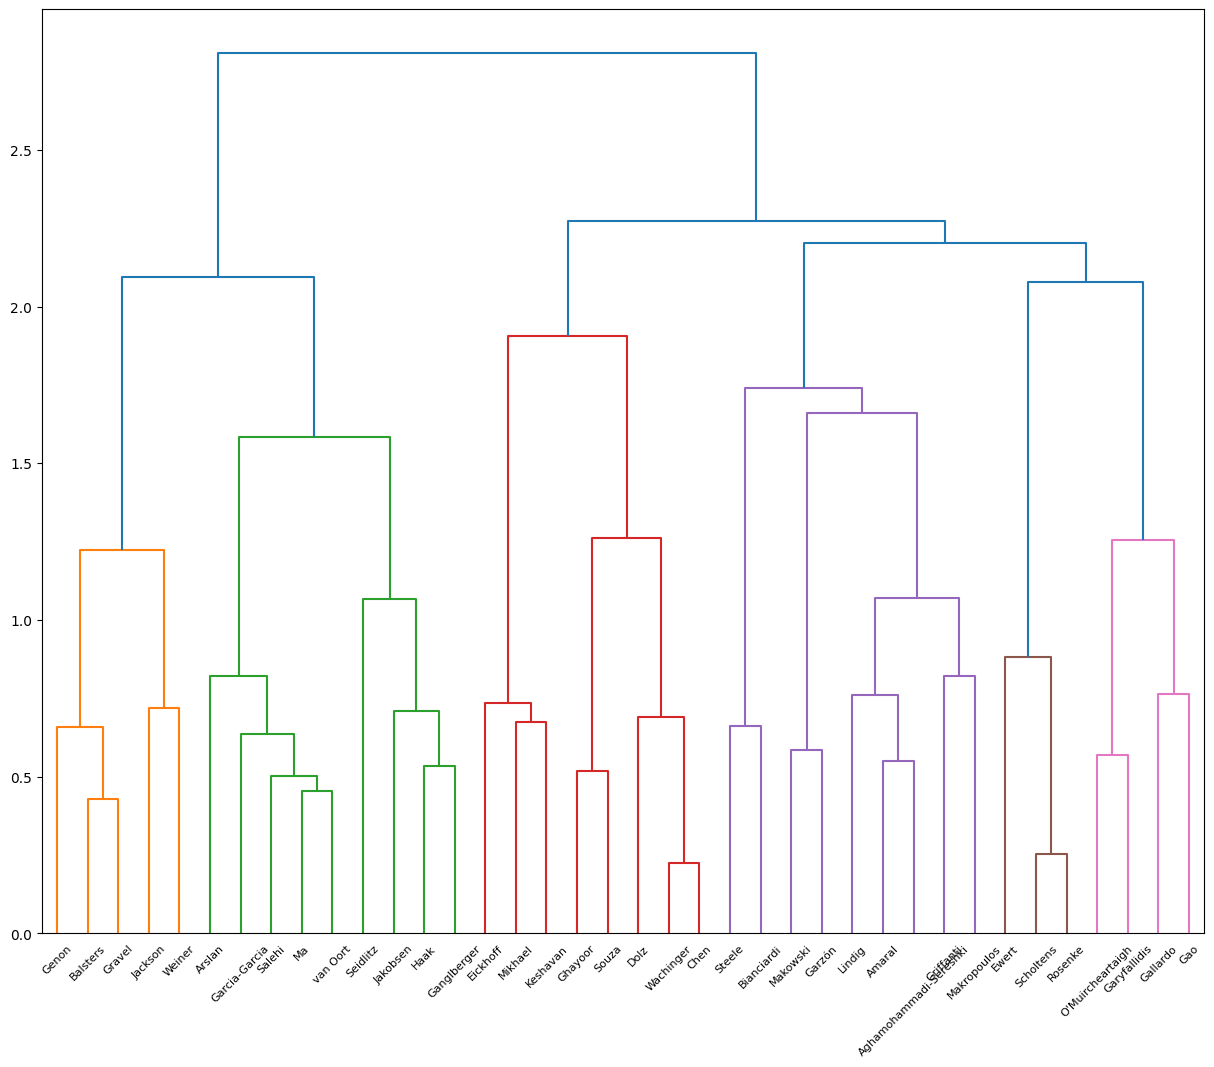

In [4]:
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
n_clusters = 7 # Set the number of clusters

# Make figures nice and big
fig_size = [15,12]
plt.rcParams["figure.figsize"] = fig_size

Xd = pd.DataFrame(X,index=range(0, data.shape[0])) # Convert the data to a pandas frame
hier = linkage(Xd, method='ward', metric='euclidean') # scipy's hierarchical clustering
res = dendrogram(hier, labels=data['Author'].to_numpy(), get_leaves=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram

# Cut the hierarchy and turn the parcellation into a dataframe
part = np.squeeze(cut_tree(hier,n_clusters=n_clusters))
part = pd.DataFrame(data=part[order],columns=["Parcel"],index=order)
plt.show()

## Similarity matrix

So, to get a better feel of the similarity between papers that was fed into the clustering procedure, we extracted the 38x38 (papers x papers) correlation matrix across features. Papers are re-ordered in the matrix according to the above hierarchy. Each "paper parcel" has been indicated by a white square along the diagonal, which represents the similarity measures between papers falling into the same parcel.

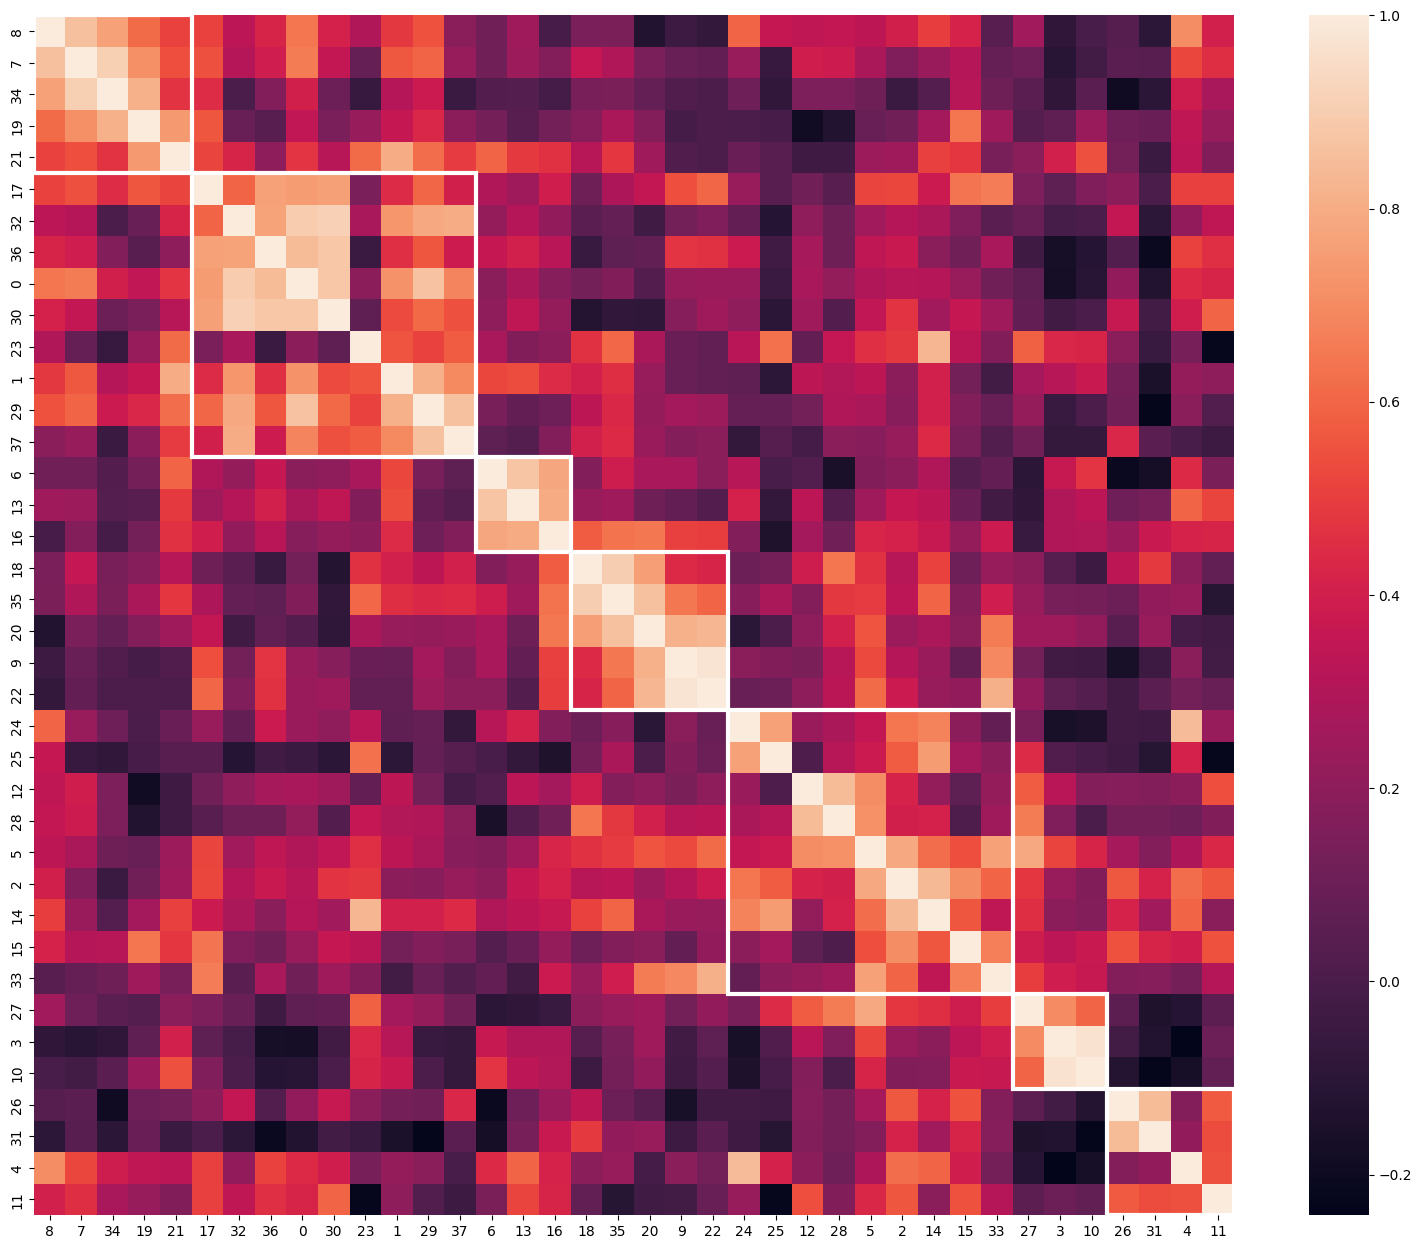

In [5]:
from matplotlib import patches
import warnings
import numpy as np
warnings.filterwarnings("ignore")

# Initialize figure/axes
fig = plt.figure()
plt.clf()
ax = fig.add_axes([0,0,1,1])

# Generate and reorder the correlation matrix
R = Xd.transpose().corr()
Rs = R.iloc[order,order]
n = len(order)

# Show the matrix with seaborn
import seaborn as sns
sns.heatmap(Rs, square=True )

# I somehow have not been able to find a good tool to do that
# So a bit of an ugly hack to add diagonal squares
# that highlight each cluster
val , ind = np.unique(part,return_index=True)
ind = np.sort(ind)
ind = np.append(ind,Rs.shape[0])
ind = ind
for ii in range(0,ind.shape[0]-1):
    p = patches.Rectangle((ind[ii+1] , ind[ii+1]),
                           ind[ii]-ind[ii + 1],
                           ind[ii]-ind[ii + 1],
                           angle=0,
                           edgecolor='white',
                           facecolor='none' ,
                           linewidth=3)
    ax.add_patch(p)
plt.show()

## Word cloud
Now, each paper of the special issue has been assigned to one and only one out of 7 possible "paper parcel". For each paper parcel, we can evaluate which words contribute more to the dominant component associated with that parcel.

<Figure size 1500x1200 with 0 Axes>

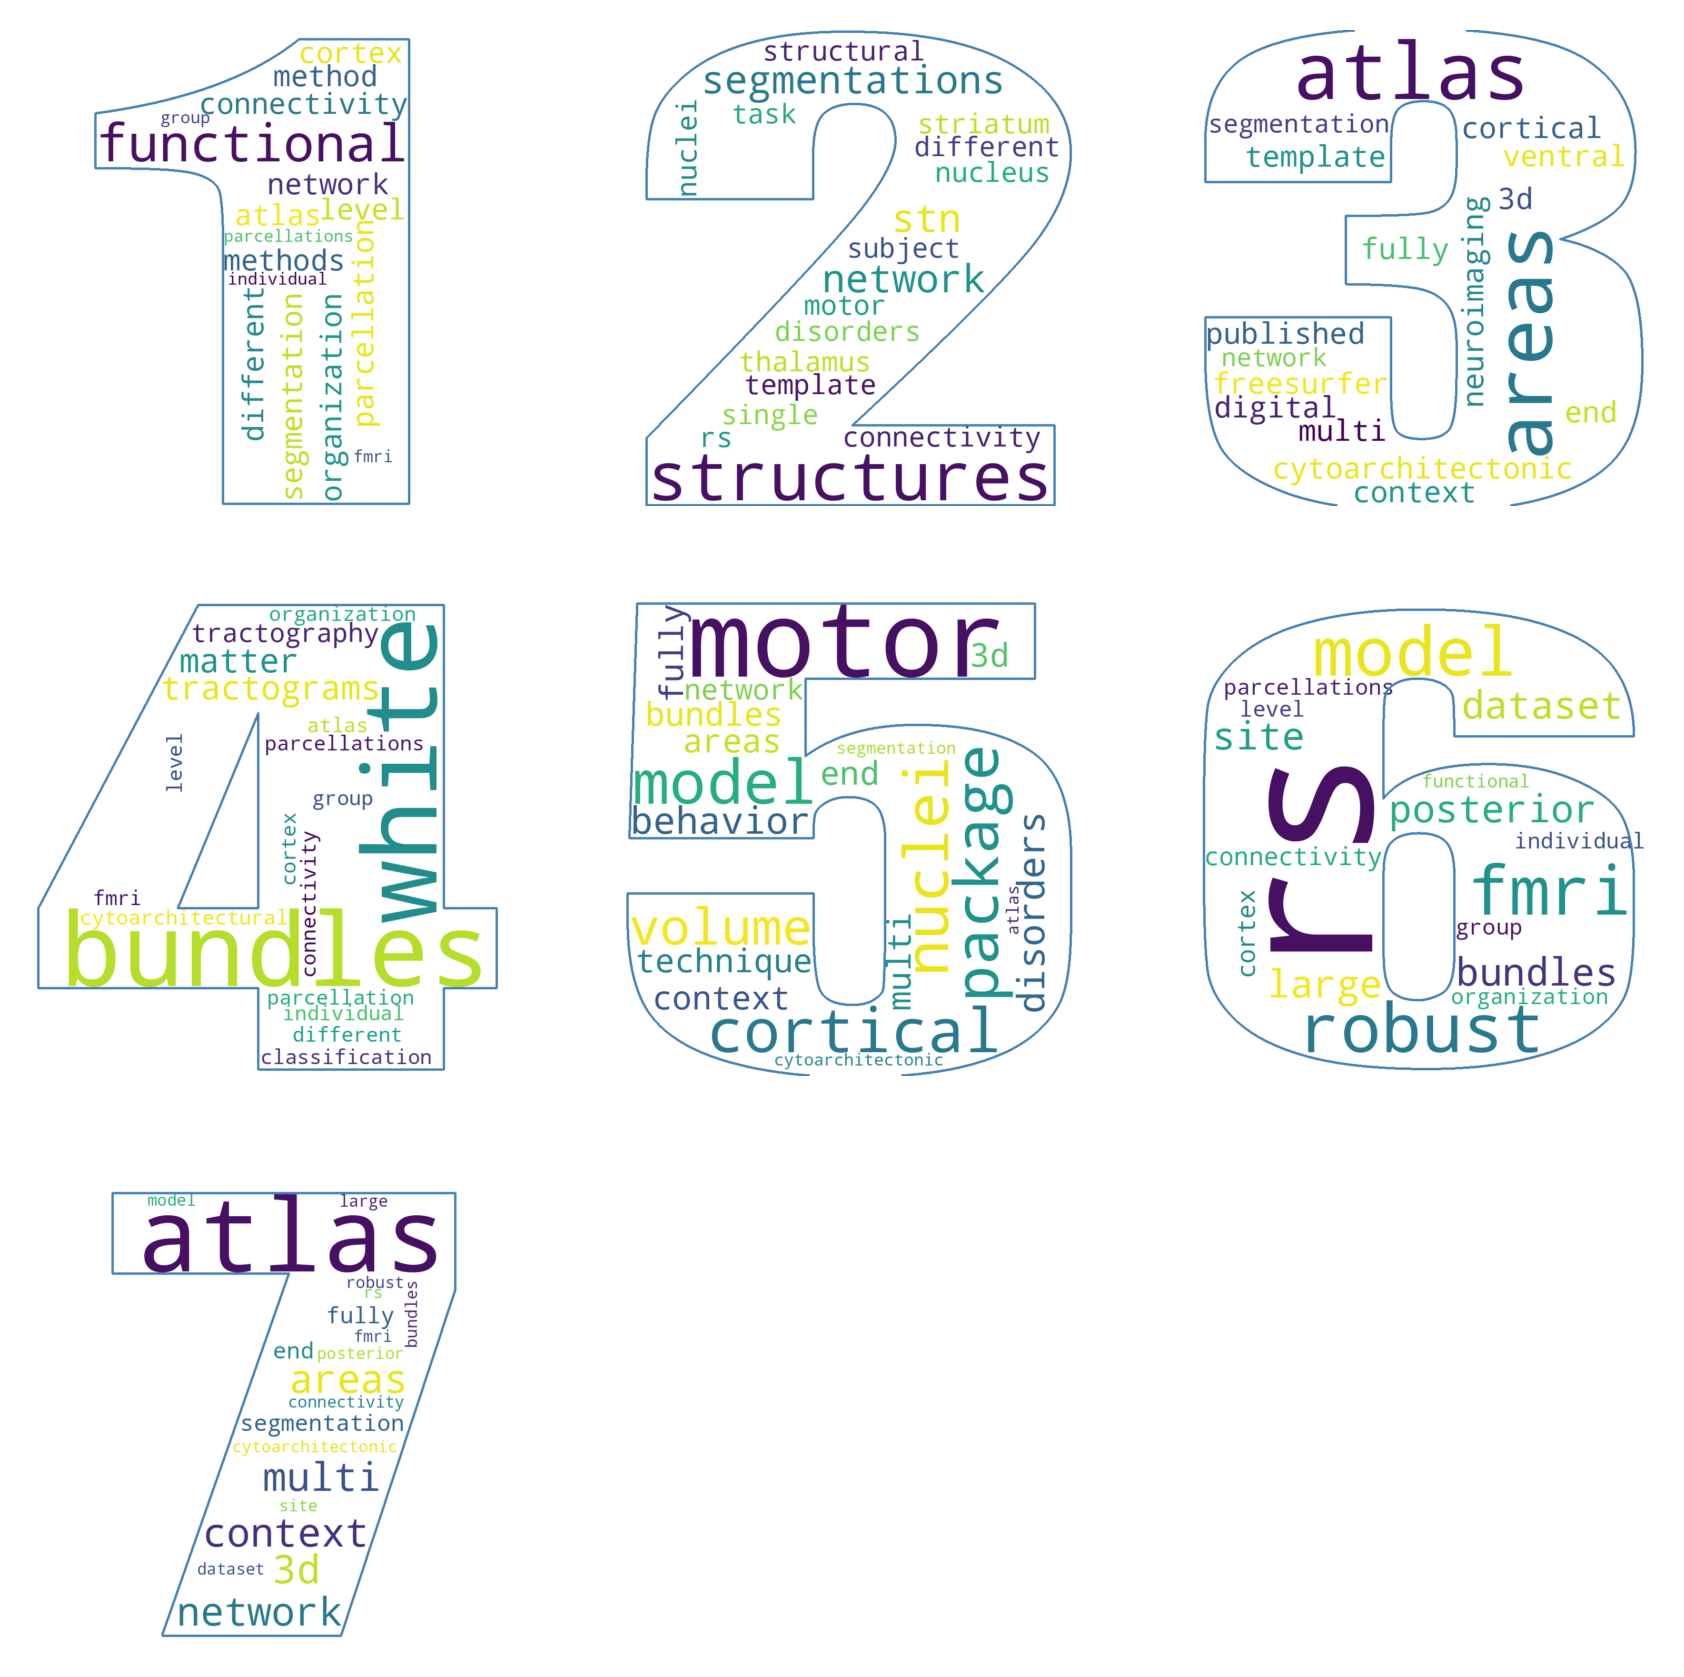

In [6]:
max_comp = 2 # Number of components to examine
max_words = 10 # Number of words to include per component
# Compute the average / std across all components
gavg = Xd.transpose()
gavg_mean = gavg.mean(axis=1)
gavg_std = gavg.std(axis=1)

# Initialize a frame to store the dominant words for each parcel
all_comp = []
words = pd.DataFrame(columns=["Parcel","word","weight"])
nb_words = 0

for cc in range(0,n_clusters): # Loop over parcels
    avg = Xd[part.Parcel==cc] # average components inside the parcel

    # Normalize from the grand average
    avg = avg.transpose()
    avg = avg.mean(axis=1)
    avg = np.divide((avg-gavg_mean),gavg_std)

    # Look for the component with highest contributions
    # There could in theory be components with negative contributions as well
    # In practice here this never happens
    val_avg , ind_avg = np.unique(-  avg ,return_index=True)
    for pos in range(0,max_comp): # We will look at the top components only
        val , ind = np.unique(- svd.components_[ind_avg[pos]],return_index=True) # Rank the components
        ind = ind[0:max_words] # Just retain the first 6 words
        for ww in ind: # Add the words and associated parcels / weights to the table
            nline = pd.DataFrame([[cc,fts[ww],np.round(100*svd.components_[ind_avg[0]][ww])]],
                            columns=["Parcel","word","weight"],
                            index=[nb_words])
            words = pd.concat([words, nline])
            nb_words = nb_words+1

# It's word cloud time!
from wordcloud import WordCloud
import imageio

n_parcels = int(words["Parcel"].max())+1
plt.clf()
word_width = 1000
word_height = 1000
fig = plt.figure(figsize=(7, 7), dpi=300)
for pp in range(0, n_parcels): # Loop over parcels
    dd = {}
    ind = words.loc[words["Parcel"]==pp].index # Select the words in selected parcel

    # Create a dictionary, where each word is associated to its weight
    for ii in ind:
        dd[words["word"][ii]] =  (words["weight"][ii] / words["weight"][ind[0]])

    mask = imageio.imread(os.path.join('numbers', f'{pp + 1}.png'))

    # Generate the word cloud
    wordcloud = WordCloud(
        background_color="white",
        random_state=0,
        relative_scaling=0,
        max_font_size=400,
        mask=mask[:, :, 3]-1,
        contour_width=5,
        contour_color='steelblue'
    ).generate_from_frequencies(dd)

    # Show the figure
    plt.subplot(3, 3, pp+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

## Categories
Thanks to the word clouds, these simple data-driven categories turned out to be fairly easily interpretable. For example, the word cloud of the category number 4 features prominently words like "white", "matter" and "bundles". If we examine the exact list of papers included in this category, we see that it is composed of four papers, which all considered parcels derived from white matter bundles with diffusion imaging.

In [7]:
# ask pandas to display full titles for the papers
pd.set_option('max_colwidth', 0)
# zero-indexing beware! parcel number 4 is filled with 3 (!)
category_4 = part.index[part['Parcel'] == 3]
tmp = data.iloc[category_4]
tmp[['Article', 'Author']]

,Article,Author
26,Concurrent white matter bundles and grey matter networks using independent component analysis,O'Muircheartaigh
31,RecoBundles: recognition of white matter bundles using local and global streamline-based registration and clustering,Garyfallidis
4,Groupwise Structural Parcellation of the Whole Cortex: A Logistic Random Effects Model Based Approach,Gallardo
11,Tests of cortical parcellation based on white matter connectivity using Diffusion Tensor Imaging,Gao


We can also check the distribution of component loadings for this category alone. As expected, there is a certain similarity in the component loadings for these papers, in particular along `component 4`:

In [8]:
import plotly.express as px
import numpy as np
df_visu = pd.melt(df_X.iloc[category_4], id_vars='First author')
fig = px.line_polar(df_visu, r='value', theta='variable', color='First author', line_close=True,
            color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

```{bibliography}
:filter: docname in docnames
```